In [88]:
import os, gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

from scipy import stats
from scipy.optimize import curve_fit

np.random.seed(42)

DATA_DIR = "mallorn-challenge/"

train_log = pd.read_csv(f"{DATA_DIR}/train_log.csv")
test_log  = pd.read_csv(f"{DATA_DIR}/test_log.csv")

print("Cell 1 OK — Data Loaded.")


Cell 1 OK — Data Loaded.


In [89]:
def process_flux(df):
    eps = 1e-6
    flux_err_safe = df["Flux_err"].replace(0, np.nan)
    demon = np.power(flux_err_safe, 2) + eps
    flux_ratio_sq = np.power(df["Flux"] , 2)/demon
    df_flux = pd.DataFrame({
        'flux_ratio_sq': flux_ratio_sq, # this exponent of 2 divide by demon
        'flux_by_flux_ratio_sq': df['Flux'] * flux_ratio_sq, # this exponent of 3 divide by demon 2 
        'w': 1 / demon
    }, index=df.index)
    return pd.concat([df, df_flux], axis=1)

In [90]:
# WAVELENGTHS = {'u': 3641, 'g': 4704, 'r': 6155, 'i': 7504, 'z': 8695, 'y': 10056}


In [91]:
def drop_low_importance_features(df, threshold, importance_map=None):
    """Drop features with mean gain below threshold; returns (df, dropped_cols)."""
    imp_map = importance_map if importance_map is not None else globals().get("mean_gain_dict", {})
    if not isinstance(imp_map, dict) or not imp_map:
        return df, []
    low_feats = [f for f, imp in imp_map.items() if imp < threshold and f in df.columns]
    if not low_feats:
        return df, []
    return df.drop(columns=low_feats, errors="ignore"), low_feats

In [92]:
def build_features_from_lightcurves(df):
    df = df.sort_values(["object_id", "Filter", "Time (MJD)"])
    # Ensure EBV/Z exist to avoid KeyError
    if 'EBV' not in df.columns:
        df['EBV'] = 0.0
    else:
        df['EBV'] = df['EBV'].fillna(0)
    if 'Z' not in df.columns:
        df['Z'] = 0.0
    else:
        df['Z'] = df['Z'].fillna(0)

    df = process_flux(df)
    df["flux_w"] = df["Flux"] * df["w"]
    # df["Filter_specific"] = df["Filter"].map(WAVELENGTHS)
    df["Flux_Real"] = df["Flux"] * (10 ** ((df["EBV"].astype(float) + 1e-9) * 3.1 / 2.5))

    # Use callables to avoid pandas versions lacking 'kurtosis' agg

    aggs = {
        'Flux': ['min', 'max', 'mean', 'std', 'median'],
        'Flux_Real': ['min', 'max', 'mean', 'std', 'median'],
        'Flux_err': ['min', 'max', 'mean', 'std', 'median'],
        'Time (MJD)': ['min', 'max'],
        'w': ['sum'],
        'flux_w': ['sum'],
        'flux_ratio_sq': ['max', 'mean', 'min', 'std'],
        'flux_by_flux_ratio_sq': ['max', 'mean', 'min', 'std']
    }

    agg = df.groupby(['object_id', 'Filter']).agg(aggs)
    agg.columns = [f"{a}_{b}" for a, b in agg.columns]
    agg = agg.reset_index()

    # Keep per-object metadata like Z if available
    z_lookup = df[['object_id', 'Z']].drop_duplicates() if 'Z' in df.columns else None
    if z_lookup is not None:
        agg = agg.merge(z_lookup, on='object_id', how='left')

    agg["flux_amp"] = agg["Flux_max"] - agg["Flux_min"]
    agg["flux_rel_amp"] = agg["flux_amp"] / (agg["Flux_mean"] + 1e-9)
    agg["time_span"] = agg["Time (MJD)_max"] - agg["Time (MJD)_min"]
    agg["flux_w_mean"] = agg["flux_w_sum"] / (agg["w_sum"] + 1e-9)
    agg["slope"] = (agg["Flux_max"] - agg["Flux_min"]) / (agg["Time (MJD)_max"] - agg["Time (MJD)_min"] + 1e-9)
    agg["asymmetry"] = (agg["Flux_mean"] - agg["Flux_median"]) / (agg["Flux_std"] + 1e-9)
    agg["peak_sharpness"] = (agg["Flux_max"] - agg["Flux_mean"]) / (agg["Flux_std"] + 1e-9)

    agg.drop(columns=["flux_w_sum", "w_sum"], inplace=True)

    agg["has_filter"] = 1
    filt = agg.pivot(index="object_id", columns="Filter", values="has_filter").fillna(0)
    filt.columns = [f"has_{c}" for c in filt.columns]

    numeric_cols = [c for c in agg.columns if c not in ["object_id", "Filter", "has_filter", "Z"]]
    wide = agg.pivot(index="object_id", columns="Filter", values=numeric_cols)
    wide.columns = [f"{c[0]}_{c[1]}" for c in wide.columns]
    wide = wide.reset_index().fillna(0)

    result = wide.merge(filt.reset_index(), on="object_id", how="left")
    if z_lookup is not None:
        result = result.merge(z_lookup, on='object_id', how='left')
    else:
        result['Z'] = 0.0

    # Compute colors/duration after pivot so required columns exist
    result['color_g_r'] = result.get('Flux_Real_max_g', pd.Series(0, index=result.index)) - result.get('Flux_Real_max_r', pd.Series(0, index=result.index))
    result['color_u_g'] = result.get('Flux_Real_max_u', pd.Series(0, index=result.index)) - result.get('Flux_Real_max_g', pd.Series(0, index=result.index))

    if {'Time (MJD)_max_g', 'Time (MJD)_min_g'}.issubset(result.columns):
        duration_obs = result['Time (MJD)_max_g'] - result['Time (MJD)_min_g']
        result['duration_rest'] = duration_obs / (1 + result['Z'])
    else:
        result['duration_rest'] = 0.0

    result[['color_g_r', 'color_u_g', 'duration_rest']] = result[['color_g_r', 'color_u_g', 'duration_rest']].fillna(0)

    return result


In [93]:
# Additional time-series and color features
EPS = 1e-12
BANDS = ["u","g","r","i","z","y"]

def safe_div(a, b):
    return a / (b + EPS)

def mad(x):
    x = np.asarray(x)
    med = np.nanmedian(x)
    return np.nanmedian(np.abs(x - med))

def max_abs_slope(t, f):
    t = np.asarray(t); f = np.asarray(f)
    if len(t) < 2:
        return np.nan
    o = np.argsort(t)
    t = t[o]; f = f[o]
    dt = np.diff(t)
    df = np.diff(f)
    good = dt != 0
    if not np.any(good):
        return np.nan
    slope = df[good] / dt[good]
    slope = slope[np.isfinite(slope)]
    if len(slope) == 0:
        return np.nan
    return np.nanmax(np.abs(slope))

def sign_flip_rate(t, f):
    t = np.asarray(t); f = np.asarray(f)
    if len(t) < 4:
        return np.nan
    o = np.argsort(t)
    f = f[o]
    d = np.diff(f)
    s = np.sign(d)
    s = s[s != 0]
    if len(s) < 3:
        return 0.0
    flips = np.sum(s[1:] != s[:-1])
    return flips / (len(s) - 1 + EPS)

def num_peaks_sig(t, f, ferr, snr_thr=3.0, min_sep_days=30.0):
    """Simple peak count: local maxima with F>snr_thr*err, separated by min_sep_days."""
    t = np.asarray(t); f = np.asarray(f); ferr = np.asarray(ferr)
    if len(t) < 5:
        return 0
    o = np.argsort(t)
    t = t[o]; f = f[o]; ferr = ferr[o]
    sig = f > snr_thr * ferr
    peaks = []
    for i in range(1, len(f)-1):
        if sig[i] and (f[i] > f[i-1]) and (f[i] > f[i+1]):
            peaks.append(i)
    if not peaks:
        return 0
    kept = [peaks[0]]
    for idx in peaks[1:]:
        if t[idx] - t[kept[-1]] >= min_sep_days:
            kept.append(idx)
    return len(kept)

def vonneumann_eta(t, f):
    """Eta = sum((f_{i+1}-f_i)^2) / ((n-1)*var(f)) on time-ordered series."""
    t = np.asarray(t); f = np.asarray(f)
    if len(t) < 3:
        return np.nan
    o = np.argsort(t)
    f = f[o]
    var = np.nanvar(f)
    if var <= 0:
        return np.nan
    df = np.diff(f)
    return np.nansum(df*df) / ((len(df)) * var + EPS)

def excess_variance(f, ferr):
    """(var(f) - mean(err^2)) / mean(f)^2"""
    f = np.asarray(f); ferr = np.asarray(ferr)
    if len(f) < 3:
        return np.nan
    v = np.nanvar(f)
    n = np.nanmean(ferr*ferr)
    mu = np.nanmean(f)
    return (v - n) / (mu*mu + EPS)

def sf_median_abs_delta(t, f, lag_lo, lag_hi):
    """Median(|ΔF|) for pairs with lag in [lag_lo, lag_hi]."""
    t = np.asarray(t); f = np.asarray(f)
    n = len(t)
    if n < 5:
        return np.nan
    o = np.argsort(t)
    t = t[o]; f = f[o]
    vals = []
    for i in range(n):
        dt = t[i+1:] - t[i]
        mask = (dt >= lag_lo) & (dt <= lag_hi)
        if np.any(mask):
            vals.extend(np.abs(f[i+1:][mask] - f[i]))
    if not vals:
        return np.nan
    return float(np.nanmedian(vals))

def _threshold_times(t, f, t_peak, f_peak, frac):
    """Return (t_rise, t_decay) for threshold frac*f_peak around t_peak."""
    thr = frac * f_peak
    t = np.asarray(t); f = np.asarray(f)
    o = np.argsort(t)
    t = t[o]; f = f[o]
    pre = (t <= t_peak) & (f >= thr)
    post = (t >= t_peak) & (f >= thr)
    t_rise = t[pre].min() if np.any(pre) else np.nan
    t_decay = t[post].max() if np.any(post) else np.nan
    return t_rise, t_decay

def fit_decay_powerlaw(t, f, t_peak, f_peak, min_pts=6):
    """Fit log(F) = a - alpha*log(dt) for post-peak points. Return (alpha, r2)."""
    t = np.asarray(t); f = np.asarray(f)
    o = np.argsort(t)
    t = t[o]; f = f[o]
    mask = (t > t_peak) & (f > 0.05*f_peak) & np.isfinite(f)
    dt = t[mask] - t_peak
    y = f[mask]
    if len(y) < min_pts:
        return np.nan, np.nan
    x = np.log(dt + EPS)
    ly = np.log(y + EPS)
    m, c = np.polyfit(x, ly, 1)
    pred = c + m*x
    ss_res = np.sum((ly - pred)**2)
    ss_tot = np.sum((ly - np.mean(ly))**2) + EPS
    r2 = 1 - ss_res/ss_tot
    alpha = -m
    return alpha, r2

def fit_decay_exponential(t, f, t_peak, f_peak, min_pts=6):
    """Fit log(F) = a - dt/tau for post-peak points. Return (tau, r2)."""
    t = np.asarray(t); f = np.asarray(f)
    o = np.argsort(t)
    t = t[o]; f = f[o]
    mask = (t > t_peak) & (f > 0.05*f_peak) & np.isfinite(f)
    dt = t[mask] - t_peak
    y = f[mask]
    if len(y) < min_pts:
        return np.nan, np.nan
    x = dt
    ly = np.log(y + EPS)
    m, c = np.polyfit(x, ly, 1)
    pred = c + m*x
    ss_res = np.sum((ly - pred)**2)
    ss_tot = np.sum((ly - np.mean(ly))**2) + EPS
    r2 = 1 - ss_res/ss_tot
    tau = -1.0/(m + EPS)
    return tau, r2

def interp_flux_at_time(g_band_df, t0, time_col, flux_col):
    """Linear interpolate flux at t0; nearest neighbor if outside range."""
    if g_band_df is None or len(g_band_df) < 2:
        return np.nan
    d = g_band_df.sort_values(time_col)
    t = d[time_col].values
    f = d[flux_col].values
    if t0 < t.min() or t0 > t.max():
        idx = np.argmin(np.abs(t - t0))
        return f[idx]
    return float(np.interp(t0, t, f))

def build_features(df,
                   time_col="Time (MJD)",
                   flux_col="Flux_Real",
                   err_col="Flux_err",
                   band_col="Filter",
                   z_col="Z",
                   snr_det=3.0):
    df = df.copy()
    if flux_col not in df.columns and "Flux" in df.columns:
        df[flux_col] = df["Flux"]
    df["SNR"] = safe_div(df[flux_col], df[err_col])

    meta = df.groupby("object_id", sort=False)[[z_col]].first()
    meta["one_plus_z"] = 1.0 + meta[z_col].fillna(0.0)

    out_rows = []

    for oid, gobj in df.groupby("object_id", sort=False):
        z = float(gobj[z_col].iloc[0]) if z_col in gobj.columns else 0.0
        opz = 1.0 + (z if np.isfinite(z) else 0.0)

        row = {"object_id": oid, "z": z}

        F = gobj[flux_col].values
        E = gobj[err_col].values
        T = gobj[time_col].values
        row["frac_neg_3sig"] = float(np.mean(F < -3.0*E))
        row["skew_all"] = float(pd.Series(F).skew())
        row["kurt_all"] = float(pd.Series(F).kurt())
        row["mad_all"] = mad(F)
        p5, p25, p75, p95 = np.nanpercentile(F, [5,25,75,95])
        row["pct_ratio_all"] = safe_div((p75-p25), (p95-p5))
        row["eta_all"] = vonneumann_eta(T, F)
        row["excess_var_all"] = excess_variance(F, E)
        row["sign_flip_rate_all"] = sign_flip_rate(T, F)

        row["sf_10_30"] = sf_median_abs_delta(T, F, 10.0, 30.0)
        row["sf_30_100"] = sf_median_abs_delta(T, F, 30.0, 100.0)
        row["sf_ratio_long_short"] = safe_div(row["sf_30_100"], row["sf_10_30"])

        byband = {b: gobj[gobj[band_col]==b] for b in BANDS}

        for b in BANDS:
            gb = byband[b]
            if len(gb) == 0:
                continue

            tb = gb[time_col].values
            fb = gb[flux_col].values
            eb = gb[err_col].values

            finite_mask = np.isfinite(fb)
            if finite_mask.sum() == 0:
                continue

            row[f"n_obs_{b}"] = len(gb)
            row[f"n_det_{b}"] = int(np.sum((gb["SNR"].values > snr_det) & (fb > 0)))

            fb_safe = np.where(np.isfinite(fb), fb, -np.inf)
            idxp = int(np.nanargmax(fb_safe))
            t_peak = float(tb[idxp])
            f_peak = float(fb_safe[idxp]) if np.isfinite(fb_safe[idxp]) else np.nan
            row[f"t_peak_{b}"] = t_peak
            row[f"F_peak_{b}"] = f_peak
            row[f"t_peak_rest_{b}"] = t_peak / opz

            det_mask = (gb["SNR"].values > snr_det) & np.isfinite(fb) & (fb > 0)
            if np.any(det_mask):
                t_det = tb[det_mask]
                row[f"t_first_det_{b}"] = float(np.min(t_det))
                row[f"t_last_det_{b}"] = float(np.max(t_det))
                row[f"duration_det_{b}"] = float(np.max(t_det) - np.min(t_det))
                row[f"duration_det_rest_{b}"] = row[f"duration_det_{b}"] / opz
            else:
                row[f"duration_det_{b}"] = np.nan
                row[f"duration_det_rest_{b}"] = np.nan

            for frac, tag in [(0.5, "50"), (1/2.512, "1mag")]:
                t_rise, t_decay = _threshold_times(tb, fb, t_peak, f_peak, frac)
                row[f"t_rise{tag}_{b}"] = t_rise
                row[f"t_decay{tag}_{b}"] = t_decay
                if np.isfinite(t_rise):
                    row[f"rise{tag}_{b}"] = (t_peak - t_rise)
                    row[f"rise{tag}_rest_{b}"] = row[f"rise{tag}_{b}"]/opz
                else:
                    row[f"rise{tag}_{b}"] = np.nan
                    row[f"rise{tag}_rest_{b}"] = np.nan
                if np.isfinite(t_decay):
                    row[f"decay{tag}_{b}"] = (t_decay - t_peak)
                    row[f"decay{tag}_rest_{b}"] = row[f"decay{tag}_{b}"]/opz
                else:
                    row[f"decay{tag}_{b}"] = np.nan
                    row[f"decay{tag}_rest_{b}"] = np.nan

            t_rise50 = row.get(f"t_rise50_{b}", np.nan)
            t_decay50 = row.get(f"t_decay50_{b}", np.nan)
            row[f"fwhm_{b}"] = (t_decay50 - t_rise50) if (np.isfinite(t_rise50) and np.isfinite(t_decay50)) else np.nan
            row[f"fwhm_rest_{b}"] = row[f"fwhm_{b}"]/opz if np.isfinite(row[f"fwhm_{b}"]) else np.nan

            rise50 = row.get(f"rise50_{b}", np.nan)
            decay50 = row.get(f"decay50_{b}", np.nan)
            row[f"asym50_{b}"] = safe_div(decay50, rise50)

            o = np.argsort(tb)
            t_sorted = tb[o]; f_sorted = np.maximum(fb[o], 0.0)
            if len(t_sorted) >= 2:
                row[f"fluence_{b}"] = float(np.trapz(f_sorted, t_sorted))
                row[f"fluence_rest_{b}"] = row[f"fluence_{b}"] / opz
            else:
                row[f"fluence_{b}"] = np.nan
                row[f"fluence_rest_{b}"] = np.nan

            row[f"max_abs_slope_{b}"] = max_abs_slope(tb, fb)
            row[f"sign_flip_rate_{b}"] = sign_flip_rate(tb, fb)
            row[f"num_peaks_sig_{b}"] = num_peaks_sig(tb, fb, eb, snr_thr=snr_det)

            row[f"mad_{b}"] = mad(fb)
            p5, p25, p75, p95 = np.nanpercentile(fb, [5,25,75,95])
            row[f"pct_ratio_{b}"] = safe_div((p75-p25), (p95-p5))
            row[f"skew_{b}"] = float(pd.Series(fb).skew())
            row[f"kurt_{b}"] = float(pd.Series(fb).kurt())

            alpha, r2p = fit_decay_powerlaw(tb, fb, t_peak, f_peak)
            tau, r2e = fit_decay_exponential(tb, fb, t_peak, f_peak)
            row[f"decay_pow_alpha_{b}"] = alpha
            row[f"fit_r2_pow_{b}"] = r2p
            row[f"decay_exp_tau_{b}"] = tau
            row[f"fit_r2_exp_{b}"] = r2e

        if len(byband["r"]) >= 1:
            br = byband["r"].sort_values(time_col)
            tpr_idx = br[flux_col].values
            if np.isfinite(tpr_idx).sum() > 0:
                tpr = float(br.loc[br[flux_col].idxmax(), time_col])
                Frp = float(br[flux_col].max())
                Fg_at_rpeak = interp_flux_at_time(byband["g"], tpr, time_col, flux_col)

                row["ratio_g_over_r_peak"] = safe_div(Fg_at_rpeak, Frp)
                if Fg_at_rpeak > 0 and Frp > 0:
                    row["color_gr_peak_mag"] = -2.5 * np.log10(Fg_at_rpeak / (Frp + EPS))
                else:
                    row["color_gr_peak_mag"] = np.nan

                t_rise1 = row.get("t_rise1mag_r", np.nan)
                t_decay1 = row.get("t_decay1mag_r", np.nan)

                def mean_color_in_window(t_lo, t_hi):
                    if not (np.isfinite(t_lo) and np.isfinite(t_hi) and t_hi > t_lo):
                        return np.nan
                    rwin = br[(br[time_col] >= t_lo) & (br[time_col] <= t_hi)]
                    if len(rwin) < 2 or len(byband["g"]) < 2:
                        return np.nan
                    cols = []
                    for tr, fr in zip(rwin[time_col].values, rwin[flux_col].values):
                        fg = interp_flux_at_time(byband["g"], tr, time_col, flux_col)
                        if fg > 0 and fr > 0:
                            cols.append(-2.5*np.log10(fg/(fr+EPS)))
                    return float(np.nanmean(cols)) if cols else np.nan

                row["color_gr_pre_mag"]  = mean_color_in_window(t_rise1, tpr) if np.isfinite(t_rise1) else np.nan
                row["color_gr_post_mag"] = mean_color_in_window(tpr, t_decay1) if np.isfinite(t_decay1) else np.nan
                row["color_gr_change_mag"] = row["color_gr_post_mag"] - row["color_gr_pre_mag"] if (np.isfinite(row.get("color_gr_pre_mag", np.nan)) and np.isfinite(row.get("color_gr_post_mag", np.nan))) else np.nan

                if np.isfinite(t_decay1) and len(byband["g"]) >= 2:
                    rwin = br[(br[time_col] >= tpr) & (br[time_col] <= t_decay1)]
                    if len(rwin) >= 3:
                        tt = []
                        cc = []
                        for tr, fr in zip(rwin[time_col].values, rwin[flux_col].values):
                            fg = interp_flux_at_time(byband["g"], tr, time_col, flux_col)
                            if fg > 0 and fr > 0:
                                tt.append(tr - tpr)
                                cc.append(-2.5*np.log10(fg/(fr+EPS)))
                        if len(cc) >= 3 and np.nanvar(tt) > 0:
                            m, c = np.polyfit(np.array(tt), np.array(cc), 1)
                            row["color_gr_slope_post"] = float(m)
                            row["color_gr_var_post"] = float(np.nanvar(cc))
                        else:
                            row["color_gr_slope_post"] = np.nan
                            row["color_gr_var_post"] = np.nan
                    else:
                        row["color_gr_slope_post"] = np.nan
                        row["color_gr_var_post"] = np.nan

        out_rows.append(row)

    feat = pd.DataFrame(out_rows).set_index("object_id")
    feat = feat.join(meta, how="left")
    return feat.reset_index()


In [94]:
def load_splits(split_ids, mode="train"):
    # Attach metadata (EBV, Z, Z_err) from the appropriate log before feature building
    meta = train_log if mode == "train" else test_log
    meta_cols = [c for c in ["object_id", "EBV", "Z", "Z_err"] if c in meta.columns]

    all_feats = []
    for i in split_ids:
        fname = f"{DATA_DIR}/split_{i:02d}/{mode}_full_lightcurves.csv"
        if os.path.exists(fname):
            df = pd.read_csv(fname)
            if meta_cols:
                df = df.merge(meta[meta_cols], on="object_id", how="left")
            # ensure EBV/Z exist
            if "EBV" not in df.columns:
                df["EBV"] = 0.0
            else:
                df["EBV"] = df["EBV"].fillna(0)
            if "Z" not in df.columns:
                df["Z"] = 0.0
            else:
                df["Z"] = df["Z"].fillna(0)
            if "Flux_Real" not in df.columns:
                df["Flux_Real"] = df["Flux"] * (10 ** ((df["EBV"].astype(float) + 1e-9) * 3.1 / 2.5))

            base_feats = build_features_from_lightcurves(df)
            ts_feats = build_features(df, time_col="Time (MJD)", flux_col="Flux_Real", err_col="Flux_err", band_col="Filter", z_col="Z", snr_det=3.0)
            merged = base_feats.merge(ts_feats, on="object_id", how="left")
            all_feats.append(merged)
            del df
            gc.collect()
    full = pd.concat(all_feats, ignore_index=True)
    aggregated = full.groupby("object_id", as_index=False).mean()
    return aggregated.copy()

In [95]:
print("Loading TRAIN splits...")
train_feats = load_splits(range(1,21), mode="train")

train = train_feats.merge(
    train_log[["object_id","Z","Z_err","EBV","target"]],
    on="object_id", how="left"
).fillna(0)

# Safety: ensure Z exists even if upstream file lacked it
if "Z" not in train.columns:
    train["Z"] = 0.0

# Drop known low-value presence flags early
initial_drop = [c for c in ["has_y","has_g","has_u"] if c in train.columns]
if initial_drop:
    train = train.drop(columns=initial_drop)

for c in train.columns:
    if "flux_w_mean" in c:
        train[c+"_x_Z"] = train[c]*train["Z"]

feature_candidates = [c for c in train.columns if c not in ["object_id","target"]]

# Manual low-importance drop list (from previous importance inspection)
manual_drop = [
    "has_y","has_g","has_u",
    "Flux_Real_max_z","flux_by_flux_ratio_sq_std_y","flux_ratio_sq_std_z","flux_ratio_sq_max_z","flux_by_flux_ratio_sq_max_z",
    "Flux_Real_std_z","slope_z","flux_by_flux_ratio_sq_mean_i","flux_by_flux_ratio_sq_std_i","flux_by_flux_ratio_sq_mean_z",
    "Time (MJD)_min_g","Flux_Real_max_i","flux_ratio_sq_mean_z","Flux_max_z","flux_ratio_sq_mean_y","flux_ratio_sq_std_y",
    "flux_ratio_sq_max_y","flux_by_flux_ratio_sq_max_y","flux_by_flux_ratio_sq_max_i","flux_by_flux_ratio_sq_mean_y",
    "flux_ratio_sq_mean_i","flux_ratio_sq_std_g","Time (MJD)_min_r","flux_by_flux_ratio_sq_std_g","Flux_Real_std_i",
    "flux_amp_i","Flux_err_median_i","flux_by_flux_ratio_sq_std_z","slope_g","flux_amp_z","flux_by_flux_ratio_sq_max_g",
    "flux_ratio_sq_max_g","Flux_err_mean_u","Flux_err_std_z","Flux_err_mean_r","Flux_err_median_r","Flux_Real_median_z",
    "Flux_Real_min_g"
 ]

# Drop zero-variance or all-zero columns
zero_var_cols = [c for c in feature_candidates if (train[c].std() == 0) or (train[c].abs().max() == 0)]

# Drop duplicate columns (same values across all rows)
dup_mask = train[feature_candidates].T.duplicated()
dup_cols = list(pd.Series(feature_candidates)[dup_mask.values])

# Drop single-unique-value columns (e.g., all 1s like has_g)
single_unique_cols = [c for c in feature_candidates if train[c].nunique(dropna=False) == 1]

columns_to_drop = sorted(set(zero_var_cols + dup_cols + single_unique_cols + manual_drop))
if columns_to_drop:
    keep_cols = [c for c in train.columns if c not in columns_to_drop]
    train = train[keep_cols]

# Remove outlier rows using robust z-score filter
num_cols = [c for c in train.columns if c not in ["object_id","target"]]
zscores = np.abs(stats.zscore(train[num_cols], nan_policy='omit'))
zscores = np.nan_to_num(zscores, nan=0.0, posinf=0.0, neginf=0.0)
mask_keep = (zscores <= 6).all(axis=1)
train = train.loc[mask_keep].reset_index(drop=True)

# Persist the columns we keep for test alignment
columns_to_drop_safe = columns_to_drop
feature_cols = [c for c in train.columns if c not in ["object_id","target"]]
X = train[feature_cols].values
y = train["target"].values

print("Train shape (after drops/outlier filter):", train.shape)

Loading TRAIN splits...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24592\3407650532.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aggregated = full.groupby("object_id", as_index=False).mean()


Train shape (after drops/outlier filter): (2444, 402)


In [96]:
# Save the cleaned training frame for inspection
out_path = "test_1.csv"
train.to_csv(out_path, index=False)
print(f"Saved {out_path} with shape {train.shape}")


Saved test_1.csv with shape (2444, 402)


In [97]:
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_preds = np.zeros(X.shape[0])

models_lgb = []
models_xgb = []
models_cat = []

pos = (y==1).sum()
neg = (y==0).sum()
scale_pos_weight = neg/(pos+1)

params_lgb = {
    "objective":"binary",
    "metric":"binary_logloss",
    "learning_rate":0.03,
    "num_leaves":96,
    "feature_fraction":0.7,
    "bagging_fraction":0.7,
    "bagging_freq":1,
    "scale_pos_weight":scale_pos_weight,
    "verbosity":-1,
}

params_xgb = {
    "max_depth":7,
    "eta":0.03,
    "subsample":0.7,
    "colsample_bytree":0.7,
    "objective":"binary:logistic",
    "eval_metric":"logloss",
    "scale_pos_weight":scale_pos_weight,
    "tree_method":"hist",
}

print("Start 3-model Ensemble Training...")

for fold,(tr,va) in enumerate(skf.split(X,y)):
    print(f"\n=== FOLD {fold+1}/{N_FOLDS} ===")

    Xtr, ytr = X[tr], y[tr]
    Xva, yva = X[va], y[va]

    # LightGBM
    dtr_lgb = lgb.Dataset(Xtr,label=ytr)
    #dtr_lgb là gì? là 
    dva_lgb = lgb.Dataset(Xva,label=yva)
    m_lgb = lgb.train(
        params_lgb, dtr_lgb, num_boost_round=1000,
        valid_sets=[dtr_lgb,dva_lgb],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )
    models_lgb.append(m_lgb)
    pred_lgb = m_lgb.predict(Xva)

    # XGBoost
    dtr_xgb = xgb.DMatrix(Xtr,label=ytr)
    dva_xgb = xgb.DMatrix(Xva,label=yva)
    m_xgb = xgb.train(
        params_xgb, dtr_xgb, num_boost_round=1200,
        evals=[(dva_xgb,"eval")],
        early_stopping_rounds=80,
        verbose_eval=False
    )
    models_xgb.append(m_xgb)
    pred_xgb = m_xgb.predict(dva_xgb)

    # CatBoost
    m_cat = CatBoostClassifier(
        depth=8,
        learning_rate=0.03,
        iterations=1500,
        loss_function="Logloss",
        eval_metric="Logloss",
        random_seed=42,
        verbose=False
    )
    m_cat.fit(Xtr, ytr, eval_set=(Xva,yva))
    models_cat.append(m_cat)
    pred_cat = m_cat.predict_proba(Xva)[:,1]

    # Ensemble → OOF
    oof_preds[va] = (pred_lgb + pred_xgb + pred_cat) / 3


Start 3-model Ensemble Training...

=== FOLD 1/5 ===
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.0259615	valid_1's binary_logloss: 0.147021



=== FOLD 2/5 ===
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.032313	valid_1's binary_logloss: 0.127597

=== FOLD 3/5 ===
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.0256114	valid_1's binary_logloss: 0.126077

=== FOLD 4/5 ===
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.0283005	valid_1's binary_logloss: 0.140088

=== FOLD 5/5 ===
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.0269042	valid_1's binary_logloss: 0.126493


In [98]:
best_thr = 0
best_f1 = 0

ths = np.linspace(0.05,0.40,200)
for t in ths:
    f1 = f1_score(y, (oof_preds>=t).astype(int))
    if f1>best_f1:
        best_f1 = f1
        best_thr = t

print("Best OOF threshold =", best_thr)
print("Best OOF F1 =", best_f1)


Best OOF threshold = 0.1520100502512563
Best OOF F1 = 0.5622775800711743


In [99]:
print("Loading TEST splits...")
test_feats = load_splits(range(1,21), mode="test")

test = test_feats.merge(
    test_log[["object_id","Z","Z_err","EBV"]],
    on="object_id", how="left"
).fillna(0)

# Safety: ensure Z exists even if upstream file lacked it
if "Z" not in test.columns:
    test["Z"] = 0.0

for c in test.columns:
    if "flux_w_mean" in c:
        test[c+"_x_Z"] = test[c]*test["Z"]

# Apply same feature drops as train
if 'columns_to_drop_safe' in globals() and columns_to_drop_safe:
    drop_now = [c for c in columns_to_drop_safe if c in test.columns]
    if drop_now:
        keep_cols = [col for col in test.columns if col not in drop_now]
        test = test[keep_cols]

# Align columns with training feature set
missing_cols = [c for c in feature_cols if c not in test.columns]
for mc in missing_cols:
    test[mc] = 0.0
extra_cols = [c for c in test.columns if c not in feature_cols + ["object_id"]]
if extra_cols:
    test = test.drop(columns=extra_cols)

test = test[["object_id"] + feature_cols]

X_test = test[feature_cols].values
dtest  = xgb.DMatrix(X_test)

sub_preds = np.zeros(X_test.shape[0])

for i in range(N_FOLDS):
    p_lgb = models_lgb[i].predict(X_test)
    p_xgb = models_xgb[i].predict(dtest)
    p_cat = models_cat[i].predict_proba(X_test)[:,1]
    sub_preds += (p_lgb + p_xgb + p_cat)/3

sub_preds /= N_FOLDS

print("Test prediction OK.")


Loading TEST splits...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24592\3407650532.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aggregated = full.groupby("object_id", as_index=False).mean()


Test prediction OK.


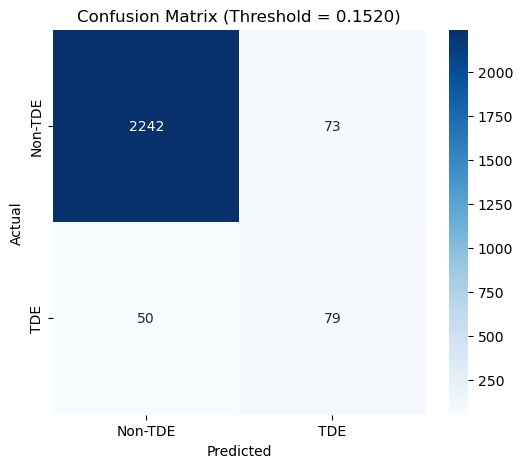

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24592\471031994.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature",


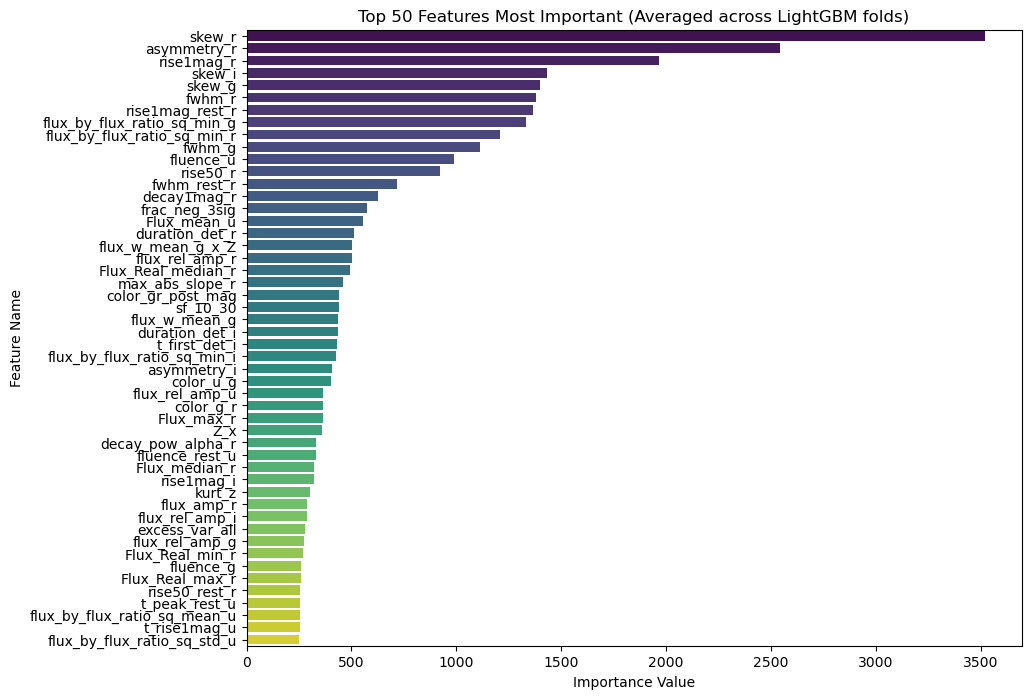

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix, classification_report

# Guard: ensure required variables exist
required_vars = ['oof_preds', 'best_thr', 'y']
missing = [v for v in required_vars if v not in globals()]
if missing:
    print(f"⚠️ Missing variables: {missing}. Run the training cells (definitions of oof_preds/best_thr/y) before this cell.")
else:
    # --- PART 1: CONFUSION MATRIX ---
    final_preds = (oof_preds >= best_thr).astype(int)
    cm = confusion_matrix(y, final_preds)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-TDE', 'TDE'], yticklabels=['Non-TDE', 'TDE'])
    plt.title(f'Confusion Matrix (Threshold = {best_thr:.4f})')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # --- PART 2: FEATURE IMPORTANCE (LightGBM models) ---
    def lgb_importances(models_lgb, feature_names):
        imp_list = []
        for m in models_lgb:
            try:
                feats = list(m.feature_name())
                imps = m.feature_importance(importance_type="gain")
            except AttributeError:
                feats = list(getattr(m, "feature_name_", feature_names or []))
                imps = m.feature_importances_
            if feature_names is not None and len(feats) == len(feature_names):
                feats = feature_names
            imp_list.append(pd.DataFrame({"Feature": feats, "Importance": imps}))
        if len(imp_list) == 0:
            return None
        return (pd.concat(imp_list, ignore_index=True)
                  .groupby("Feature", as_index=False)["Importance"].mean())

    lgb_imp = lgb_importances(models_lgb, feature_cols if 'feature_cols' in globals() else None)
    if lgb_imp is not None and len(lgb_imp) > 0:
        plt.figure(figsize=(10, 8))
        sns.barplot(x="Importance", y="Feature",
                    data=lgb_imp.sort_values(by="Importance", ascending=False).head(50),
                    palette="viridis")
        plt.title('Top 50 Features Most Important (Averaged across LightGBM folds)')
        plt.xlabel('Importance Value')
        plt.ylabel('Feature Name')
        plt.show()
    else:
        print("⚠️ No LightGBM models available to plot feature importance.")


In [101]:
if lgb_imp is not None and len(lgb_imp) > 0:
    bottom_n = 50  # adjust as needed
    low_imp = lgb_imp.sort_values(by="Importance", ascending=True).head(bottom_n)
    print(f"Lowest {bottom_n} features by mean gain importance:")
    display(low_imp)

Lowest 50 features by mean gain importance:


,Feature,Importance
284,num_peaks_sig_y,0.000027
283,num_peaks_sig_u,0.001243
347,t_decay1mag_i,0.400847
285,num_peaks_sig_z,0.543572
390,t_rise50_r,0.729359
280,num_peaks_sig_g,0.819014
281,num_peaks_sig_i,0.862135
316,rise50_rest_g,0.919090
152,duration_det_rest_u,1.033876
354,t_decay50_r,1.428470


In [102]:
threshold_list = [best_thr, 
                  best_thr-0.01,
                  best_thr+0.01,
                  best_thr-0.02,
                  best_thr+0.02]

print("Use thresholds:", threshold_list)

for idx, thr in enumerate(threshold_list,1):
    pred = (sub_preds >= thr).astype(int)

    sub_df = pd.DataFrame({
        "object_id": test["object_id"],
        "prediction": pred
    })

    fname = f"submission_thr{idx}_{thr:.3f}.csv"
    sub_df.to_csv(fname,index=False)

    print(f"Saved {fname} | positives = {pred.sum()}")


Use thresholds: [0.1520100502512563, 0.1420100502512563, 0.1620100502512563, 0.1320100502512563, 0.1720100502512563]
Saved submission_thr1_0.152.csv | positives = 448
Saved submission_thr2_0.142.csv | positives = 472
Saved submission_thr3_0.162.csv | positives = 431
Saved submission_thr4_0.132.csv | positives = 506
Saved submission_thr5_0.172.csv | positives = 410
